# Assignment 2: Methods and Plan & Computational Code and Output

## (1) (Carried over from Assignment 1 for reference) Data Description
The Sleep Health and Lifestyle Dataset contains 400 observations and 13 variables, providing insights into sleep patterns, lifestyle factors, and cardiovascular health. 
The dataset includes numerical and categorical variables. 
Source: The data source is artificial (i.e., the author of the dataset created synthetic data for illustrative purposes).
Citation: Dataset retrieved from: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data.

Table of variable name, type and description:

| Variable                  | Type        | Description                                   |
|---------------------------|------------|-----------------------------------------------|
| **Person ID**             | Categorical | Unique identifier for each individual         |
| **Gender**                | Categorical | Male/Female                                  |
| **Age**                   | Numerical   | Age in years                                 |
| **Occupation**            | Categorical | Type of profession                          |
| **Sleep Duration**        | Numerical   | Hours of sleep per day                      |
| **Quality of Sleep**      | Numerical   | Self-reported sleep quality (1-10)          |
| **Physical Activity Level** | Numerical | Minutes of physical activity per day       |
| **Stress Level**          | Numerical   | Self-reported stress level (1-10)           |
| **BMI Category**          | Categorical | Underweight, Normal, Overweight             |
| **Blood Pressure**        | Numerical   | Systolic/Diastolic measurement              |
| **Heart Rate**            | Numerical   | Beats per minute (bpm)                      |
| **Daily Steps**           | Numerical   | Number of steps per day                     |
| **Sleep Disorder**        | Categorical | None, Insomnia, Sleep Apnea                 |


## (1) Question of Interest
Can we predict whether an individual has a sleep disorder based on the available relevant categories in the dataset? (modified to include all variables in the dataset based on feedback from Assignment 1).
Column removed: Person ID.
Reason: This is a unique identifier for each individual and does not provide any meaningful information for prediction or analysis.

## Method Selection
We will use binary logistic regression implemented with glm() to predict whether an individual has a sleep disorder (Yes/No = 1/0). 

### This method is appropriate because:

The response variable (Sleep_Disorder, which is a categorical variable with 3 categories) can be transformed into a binomial variable (i.e., has Sleep disorder/ doesn't have sleep disoder).
Logistic regression models the probability of an outcome using a logistic function.
It allows us to analyze how the response variables influence the likelihood of having a sleep disorder.

### Assumptions:
1) Binary Response: The response variable must have only two categories (Yes/No).
2) Independence: Observations must be independent of one another.
3) Variance Structure: The variance follows a binomial distribution, highest when 
p=0.5.
4) Linearity in Log-Odds: The log of the odds should have a linear relationship with the predictors.

### Potential Limitations: 
1) Linearity Assumption: If the relationship between predictors and log-odds is non-linear, transformations may be needed.
2) Class Imbalance: Unequal distribution of 1/0 cases may affect predictive performance.
3) Unobserved Variables: Other important factors (e.g., genetics, caffeine intake) which may be indicators for sleep disorders are not included in this model.

## (2) Computational Code and Output

In [1]:
library(tidyverse)
library(caret)
library(pROC)
library(boot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melanoma




In [10]:
# Load the dataset
sleep_data <- read_csv("https://raw.githubusercontent.com/Tarun-Narayan/STAT301-GroupProject/refs/heads/main/sleep_health.csv", show_col_types = FALSE)

# Clean data
sleep_data <- sleep_data %>%
  drop_na()

# Removing duplicates
sleep_data <- sleep_data %>%
  distinct()

# Renaming column names to remove space
sleep_data <- sleep_data %>%
  rename(Sleep_Duration = `Sleep Duration`, 
         Stress_Level = `Stress Level`, 
         Sleep_Disorder = `Sleep Disorder`,
         BMI_Category = `BMI Category`,
         Blood_Pressure = `Blood Pressure`)

# Combining 'Normal Weight' and 'Normal' into a single category
sleep_data <- sleep_data %>%
  mutate(BMI_Category = ifelse(BMI_Category == "Normal Weight", "Normal", BMI_Category))

In [11]:
sleep_data <- sleep_data %>%
  # Splitting Blood pressure into Systolic BP and Diastolic BP
  separate(Blood_Pressure, into = c("Systolic_BP", "Diastolic_BP"), sep = "/", convert = TRUE) %>% 
  mutate(Sleep_Disorder = ifelse(Sleep_Disorder == "None", 0, 1), 
         Sleep_Disorder = as.factor(Sleep_Disorder),
         BMI_Category = as.factor(BMI_Category))

# Split into train (70%) and test (30%) sets
set.seed(123) 
sleep_train <- sleep_data %>% slice_sample(prop = 0.7)
sleep_test <- sleep_data %>% anti_join(sleep_train, by = "Person ID")

# Remove ID column
sleep_train <- sleep_train %>% select(-`Person ID`)
sleep_test <- sleep_test %>% select(-`Person ID`)
head(sleep_train)
nrow(sleep_train)

Gender,Age,Occupation,Sleep_Duration,Quality of Sleep,Physical Activity Level,Stress_Level,BMI_Category,Systolic_BP,Diastolic_BP,Heart Rate,Daily Steps,Sleep_Disorder
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<dbl>,<dbl>,<fct>
Male,42,Lawyer,7.8,8,90,5,Normal,130,85,70,8000,0
Male,29,Doctor,6.0,6,30,8,Normal,120,80,70,8000,0
Male,43,Salesperson,6.5,6,45,7,Overweight,130,85,72,6000,1
Female,51,Nurse,6.1,6,90,8,Overweight,140,95,75,10000,1
Female,37,Accountant,7.2,8,60,4,Normal,115,75,68,7000,0
Female,51,Engineer,8.5,9,30,3,Normal,125,80,65,5000,0


[1] 261

In [13]:
# Fit logistic regression model using glm()
logit_model <- glm(Sleep_Disorder ~ ., data = sleep_train, family = binomial)

summary(logit_model)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Sleep_Disorder ~ ., family = binomial, data = sleep_train)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)                    -7.004e+03  8.850e+05  -0.008   0.9937  
GenderMale                     -9.985e+01  1.236e+04  -0.008   0.9936  
Age                            -7.639e-01  4.431e-01  -1.724   0.0847 .
OccupationDoctor               -3.289e+02  4.257e+04  -0.008   0.9938  
OccupationEngineer             -3.156e+02  5.405e+04  -0.006   0.9953  
OccupationLawyer               -3.180e+02  5.405e+04  -0.006   0.9953  
OccupationManager              -1.786e+02  2.196e+05  -0.001   0.9994  
OccupationNurse                -3.449e+02  4.173e+04  -0.008   0.9934  
OccupationSales Representative -3.543e+02  1.917e+05  -0.002   0.9985  
OccupationSalesperson           2.687e+01  2.146e+04   0.001   0.9990  
OccupationScientist            -3.523e+02  4.745e+07   0.000   1.0000  
OccupationSoftware Engineer    -1.965e+02

Setting levels: control = 0, case = 1

Setting direction: controls < cases



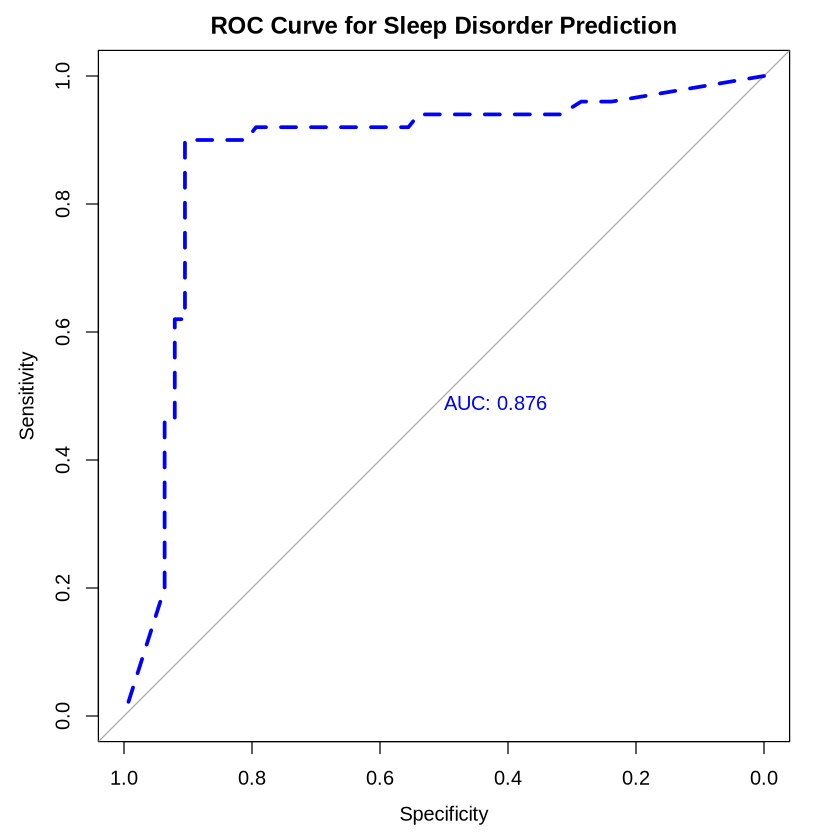

In [14]:
# Predict on test set
sleep_test$Predicted_Prob <- predict(logit_model, newdata = sleep_test, type = "response")
sleep_test$Predicted_Disorder <- ifelse(sleep_test$Predicted_Prob > 0.5, "1", "0")

# Confusion matrix
#conf_matrix <- confusionMatrix(
#    data = as.factor(sleep_test$Predicted_Disorder),
#    reference = as.factor(sleep_test$Sleep_Disorder),
#    positive = "1"
#)
#print(conf_matrix)

# ROC Curve
ROC_logit <- roc(
  response = as.numeric(sleep_test$Sleep_Disorder) - 1,  
  predictor = sleep_test$Predicted_Prob
)

# Plot ROC Curve
plot(ROC_logit,
     print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
     main = "ROC Curve for Sleep Disorder Prediction")

## Interpretation of results
The ROC curve shows that the logistic regression model performs well in predicting sleep disorders, with an AUC of 0.876, indicating strong discriminatory power. The model effectively distinguishes between individuals with and without sleep disorders, as seen from the steep rise in sensitivity. This confirms that these factors (i.e., Age, BMI, Sleep duration, Blood Pressure, etc.) play a significant role in sleep disorder classification. Further refinement, such as incorporating additional predictors or handling potential class imbalances, could enhance model performance.